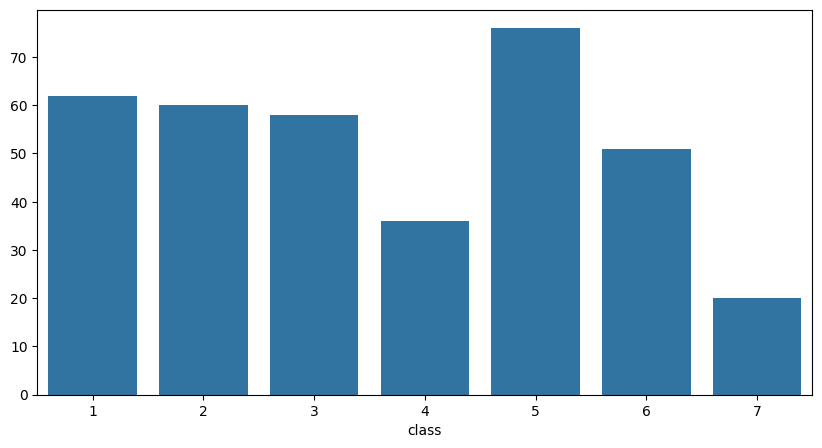

In [548]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from peakutils import baseline
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

df = pd.read_csv('data.csv')
df = df[df['class'] != 8]
train_data, test_data = train_test_split(df, test_size=0.2, shuffle = True, random_state=42)

plt.figure(figsize=(10, 5))
sns.barplot(x=df['class'].value_counts().index, y=df['class'].value_counts().values)
plt.show()

In [549]:

map = {
    'transparency': {'o': 1, 't': 2, 's': 3},
    'color': {'white': 1, 'none': 2, 'blue': 3,
              'black': 4, 'green':5, 'red': 6,
              'orange': 7, 'gray': 8, 'yellow': 9,
              'purple': 10},
    'device_id': {'B0236F1F2D02C632': 1, 'D02B30ACFD92433E': 2,
                  'B02EFC17B97B46B2': 3, '802215F15396F9FE': 4},
}
train_data = train_data.replace(map)
train_data

C:\Users\reach\AppData\Local\Temp\ipykernel_18832\3792681325.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data = train_data.replace(map)


,class,id,color,transparency,device_id,spectrum_0 + 740,spectrum_1 + 740,spectrum_2 + 740,spectrum_3 + 740,spectrum_4 + 740,...,sample_raw_321 + 740,sample_raw_322 + 740,sample_raw_323 + 740,sample_raw_324 + 740,sample_raw_325 + 740,sample_raw_326 + 740,sample_raw_327 + 740,sample_raw_328 + 740,sample_raw_329 + 740,sample_raw_330 + 740
209,4,30,5,1,4,0.166425,0.171267,0.176470,0.181951,0.187715,...,2.52,2.42,2.32,2.20,2.06,1.92,1.76,1.59,1.40,1.20
338,6,64,2,2,3,1.224040,1.222989,1.221854,1.220812,1.219938,...,8.78,8.42,8.02,7.56,7.07,6.52,5.94,5.31,4.65,3.94
357,7,18,1,3,4,0.256470,0.256815,0.257105,0.257289,0.257364,...,1.85,1.78,1.70,1.62,1.52,1.41,1.30,1.17,1.03,0.88
75,2,19,4,1,4,0.125029,0.125157,0.125292,0.125405,0.125485,...,0.92,0.89,0.85,0.80,0.76,0.70,0.65,0.58,0.51,0.44
84,2,28,1,3,4,0.244256,0.244085,0.243875,0.243581,0.243196,...,1.11,1.07,1.03,0.97,0.91,0.85,0.78,0.71,0.62,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2,11,3,1,4,0.061729,0.062024,0.062407,0.062877,0.063446,...,1.69,1.63,1.55,1.47,1.39,1.29,1.18,1.07,0.94,0.81
106,2,50,4,1,2,1.035098,1.034636,1.034294,1.034104,1.034010,...,6.68,6.42,6.12,5.79,5.43,5.02,4.58,4.11,3.61,3.06
270,5,74,1,1,1,0.577730,0.578829,0.579991,0.581201,0.582474,...,3.75,3.60,3.44,3.25,3.04,2.82,2.57,2.31,2.03,1.72
348,7,6,1,1,4,0.848607,0.828112,0.808462,0.789968,0.772597,...,6.57,6.32,6.04,5.73,5.39,5.01,4.60,4.15,3.67,3.14


## Balancing the minority classes (Oversampling)

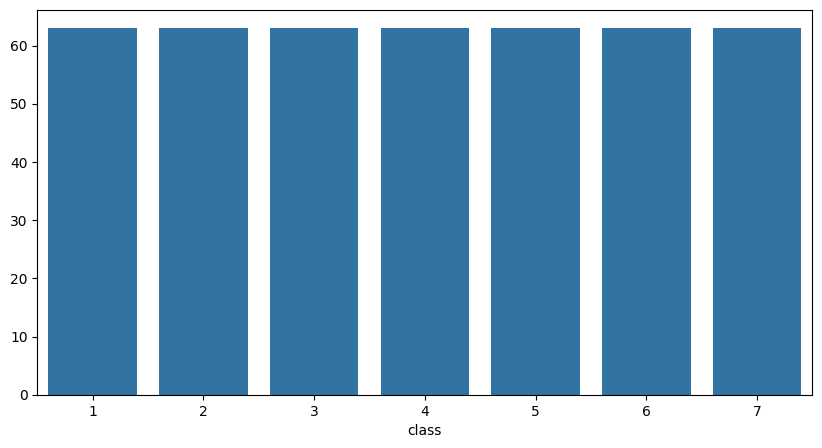

In [550]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=42)
x_train, y_train = oversampler.fit_resample(train_data.iloc[:, 1:], train_data['class'])
train_data = pd.concat([y_train, x_train], axis=1)
train_data = pd.DataFrame(train_data, columns=train_data.columns)

plt.figure(figsize=(10, 5))
sns.barplot(x=train_data['class'].value_counts().index, y=train_data['class'].value_counts().values)
plt.show()

In [551]:
def plot_signal(train_data):
    for i, row in train_data.iterrows():
        plt.plot(range(len(row)), row.values)
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.title('Spectral Data for All Samples')
    plt.show()

## Data after Oversampling

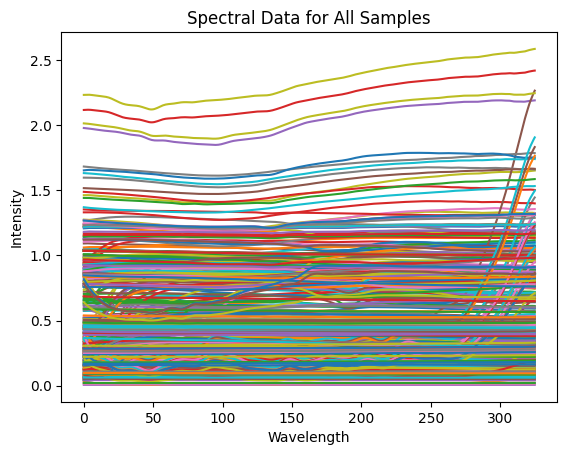

In [552]:
plot_signal(train_data.iloc[:, 5:331])

## Baseline Correction

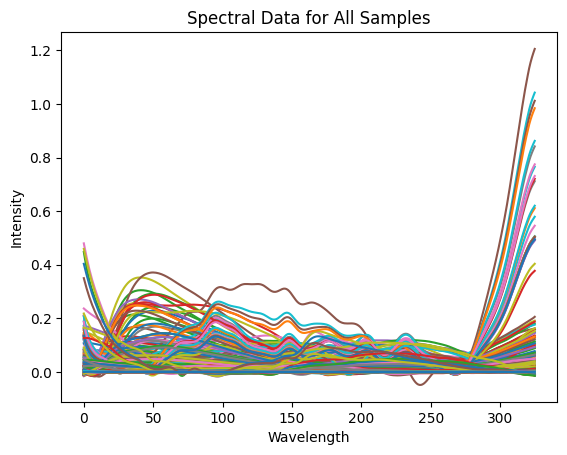

In [ ]:
train_data.iloc[:, 5:331] = pd.DataFrame(np.array([row - baseline(row, deg=2) for i, row in train_data.iloc[:, 5:331].iterrows()]))
test_data.iloc[:, 5:331] = pd.DataFrame(np.array([row - baseline(row, deg=2) for i, row in test_data.iloc[:, 5:331].iterrows()]))
plot_signal(train_data.iloc[:, 5:331])

## Normalizing data

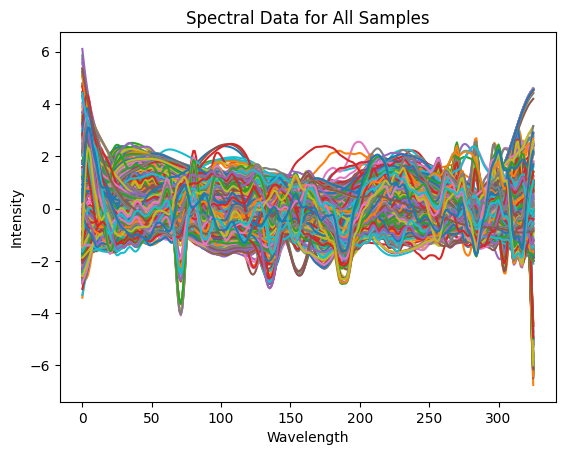

In [ ]:
"https://stackoverflow.com/questions/49960288/how-to-standardize-rows-in-pandas"

train_data.iloc[:, 5:331] = train_data.iloc[:, 5:331].sub(train_data.iloc[:, 5:331].mean(1), axis=0).div(train_data.iloc[:, 5:331].std(1), axis=0)
test_data.iloc[:, 5:331] = test_data.iloc[:, 5:331].sub(test_data.iloc[:, 5:331].mean(1), axis=0).div(test_data.iloc[:, 5:331].std(1), axis=0)
plot_signal(train_data.iloc[:, 5:331])

## Savitzky Golay Filter

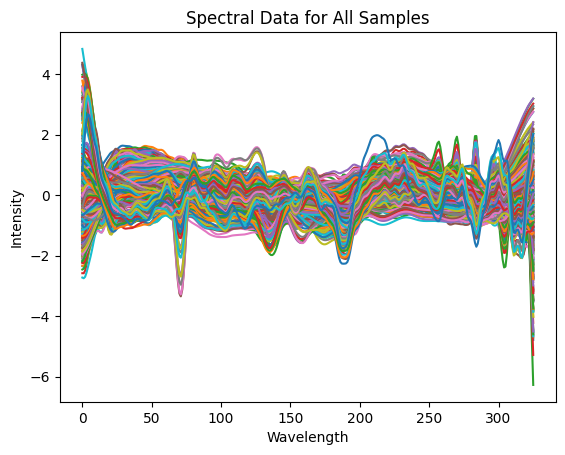

In [ ]:
signal = pd.DataFrame(savgol_filter(train_data.iloc[:, 5:331] , window_length=11, polyorder=3, axis=0))
signal = pd.DataFrame(savgol_filter(test_data.iloc[:, 5:331] , window_length=11, polyorder=3, axis=0))
plot_signal(signal)